<a href="https://colab.research.google.com/github/shifubear/Hyperdimensional-Data-Modulation/blob/main/Hyper_Dimensional_Modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 

Hyper-dimensional computing is an area of research that has been gaining attention recently. A key procedure is to encode the information to high dimensions, which has some key properties that behave similarly to the way our brains process information. 

In this report, I run three experiments to determine how accurately data that has been encoded in this manner can be decoded. Three experiments are performed. 

In the first experiment, I encode an image from the MNIST dataset using four different sizes for the high dimensional vector, and observe how well the image can be decoded. I found that the higher the dimension of the high dimensional vector, the better the accuracy of the reconstruction.  

The second experiment is similar to the first experiment, but a larger image is used. 

The third experiment tests the robustness of the decoding algorithm. Various percentages of information loss from the hyper dimensional vectors are simulated, and the decoding algorithm is run on this vector. 

In [ ]:
## Load required packages 

from scipy import fft 
import numpy as np 
from keras.datasets import mnist 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image, ImageOps
import requests
import random 

(train_X, train_y), (test_X, test_y) = mnist.load_data()
np.set_printoptions(threshold=100)

# Code

The following is the code that was written for the project.

In [ ]:
# Utility methods 

def draw_mnist(data, axs=None):
  """
  Utility function to take MNIST data in any shape and draw the plot
  """
  if axs == None:
    plt.imshow(data.reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()
  else: 
    axs.imshow(data.reshape(28, 28), cmap=plt.get_cmap('gray'))
    axs.axis('off')


def hamming_error(V1, V2):
  """ 
  Utility function to compute the hamming distance between two hyper-dimensional 
  vectors
  """
  total = 0
  for i in range(len(V1)):
    total += np.abs(V1[i] - V2[i])

  return total

In [ ]:
# HD Encoder class 

class HDEncoder:
  """
  HD Encoder to encode given data as HD vectors 
  """
  def __init__(self, n, D = 10000): 
    self.n = n 
    self.D = D 
    self.B = [ 2 * np.random.randint(2, size=self.D) - 1 for i in range(self.n) ]
    self.H = np.zeros(self.D)
    self.original = []

  def encode(self, features):
    """
    Takes a 1xn feature vector and stores the encoded hypervector in the class. 

    The encoded data usually needs to be sent with the basis vectors used for the encoding 
    so this is modeled by storing all the necessary information in a single class, 
    for the convenience of the decoder. 
    """ 
    self.original = features 

    for i, f in enumerate(features): 
      self.H = self.H + f * self.B[i]

  def drop_random(self, R):
    """
    Sets the values of R random indices to the value 0 to simulate dropped dimensions. 
    """
    indices = random.sample(range(1, self.D), R)
    
    for i in indices: 
      self.H[i] = 0

  def decode(self, iterations, verbose=False):
    """
    Uses the basis vectors to decode the encoded feature vector, until one of the 
    termination conditions is satisfied. 

    Termination conditions: 
      - Max number of iterations reached 
      - Variance is below threshold 
    """
    # Returning data 
    F = []

    features = np.zeros(self.n)

    for i in range(self.n):
      features[i] = np.round((self.H @ self.B[i]) / self.D)
    
    F.append(features)

    if iterations != 1:
      # Preparation
      Fprev = features
      Hprev = self.H

      # Main loop 
      for i in range(1, iterations): 
        Fi = np.zeros(self.n)
        Hi = np.zeros(self.D)
        dH = np.zeros(self.D)
        Ei = np.zeros(self.n) 

        # Encoding step 
        for j, f in enumerate(Fprev):
          Hi = Hi + f * self.B[j]

        # Determine error 
        dH = self.H - Hi 

        # Value discovery 
        for j in range(self.n):
          Ei[j] = np.round((dH @ self.B[j]) / self.D)

        # Feature estimation 
        Fi = Fprev + Ei 

        F.append(Fi)
        # Update values 
        Hprev = Hi 
        Fprev = Fi 

    return F 


# Experiments

To demonstrate the decoding process and the accuracy of information retrieval, the following sections run a few different experiments.  

## Experiment 1: Small image 

For this experiment, the following image from the MNIST dataset will be encoded.

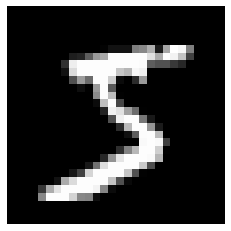

In [ ]:
data1 = train_X[0] 
draw_mnist(data1)

### Encoding step

Encode the feature vector into the vector H using three different values of D. 

In [ ]:
# Test variables 
# train_X[0].reshape(1, 784)[0]
en_1000 = HDEncoder(28 * 28, D=1000)
en_1000.encode(data1.reshape(1, 784)[0])

en_4000 = HDEncoder(28 * 28, D=4000)
en_4000.encode(data1.reshape(1, 784)[0])

en_7000 = HDEncoder(28 * 28, D=7000)
en_7000.encode(data1.reshape(1, 784)[0])

en_10000 = HDEncoder(28 * 28, D=10000)
en_10000.encode(data1.reshape(1, 784)[0])

print("D = 1000:", en_1000.H, ", \n shape: ", en_1000.H.shape, "\n")
print("D = 4000:", en_4000.H, ", \n shape: ", en_4000.H.shape, "\n")
print("D = 7000:", en_7000.H, ", \n shape: ", en_7000.H.shape, "\n")
print("D = 10000:", en_10000.H, ", \n shape: ", en_10000.H.shape, "\n")


D = 1000: [  471.   473.  1211. ... -1971. -1785.  1381.] , 
 shape:  (1000,) 

D = 4000: [ -615. -2961. -1801. ...  1331.  4087. -4279.] , 
 shape:  (4000,) 

D = 7000: [-1067.    77.   103. ...   997.  1141.  1767.] , 
 shape:  (7000,) 

D = 10000: [ -157. -1083.   -83. ...  1741.  1987.  -323.] , 
 shape:  (10000,) 



### Decoding step 

The following demonstrates the decoding step for various values of $D$. As can be seen below, the decoding requires a sufficiently high value of $D$ to see good results, and the higher the $D$ the faster the convergence is to the original image. 

In [ ]:
iterations = 10
F = {} 
F[1000] = en_1000.decode(iterations)
F[4000] = en_4000.decode(iterations)
F[7000] = en_7000.decode(iterations)
F[10000] = en_10000.decode(iterations)

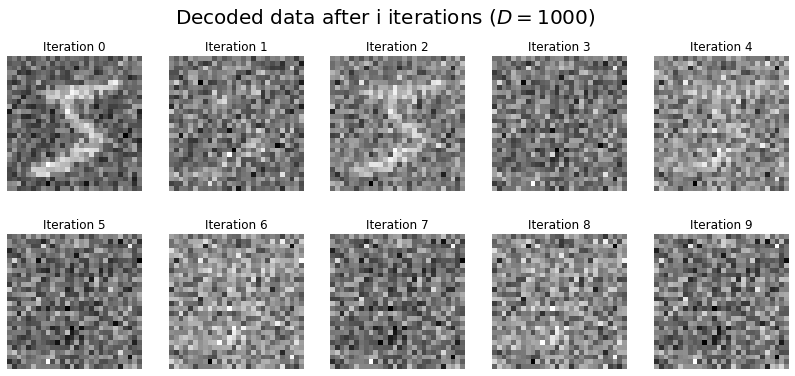

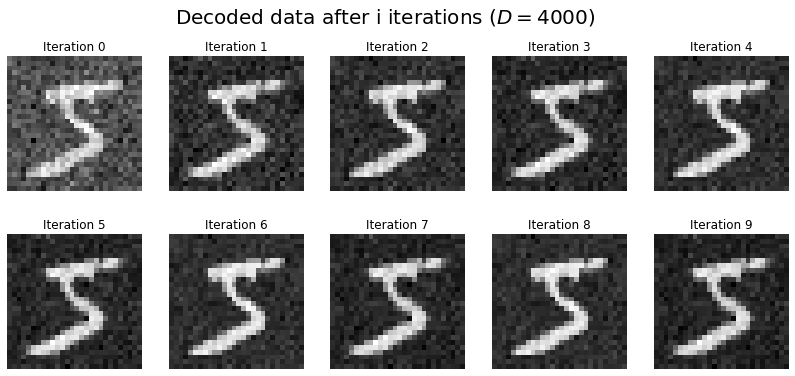

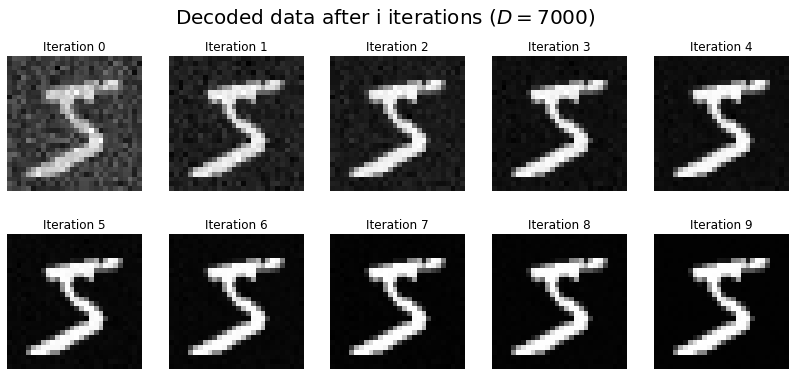

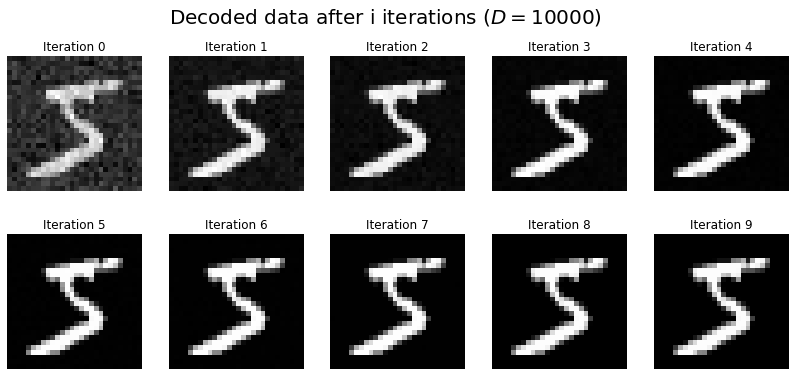

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  draw_mnist(F[1000][i], axs=axs[idx, idy])
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded data after i iterations ($D=1000$)", fontsize=20)
plt.show()

print()
print()

fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  draw_mnist(F[4000][i], axs=axs[idx, idy])
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded data after i iterations ($D=4000$)", fontsize=20)
plt.show()

print()
print()

fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  draw_mnist(F[7000][i], axs=axs[idx, idy])
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded data after i iterations ($D=7000$)", fontsize=20)
plt.show()

print()
print()

fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  draw_mnist(F[10000][i], axs=axs[idx, idy])
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded data after i iterations ($D=10000$)", fontsize=20)
plt.show()

---

To compare the performance by values of $D$, examine the following plot of each iteration and its decoding accuracy. 

In [ ]:
var = {}
error = {} 

for d in [1000, 4000, 7000, 10000]:
  var[d]   = [] 
  error[d] = []
  for i in range(iterations):
    var[d].append(np.var(F[d][i]))
    e = hamming_error(F[d][i], data1.reshape(784))
    error[d].append(e)

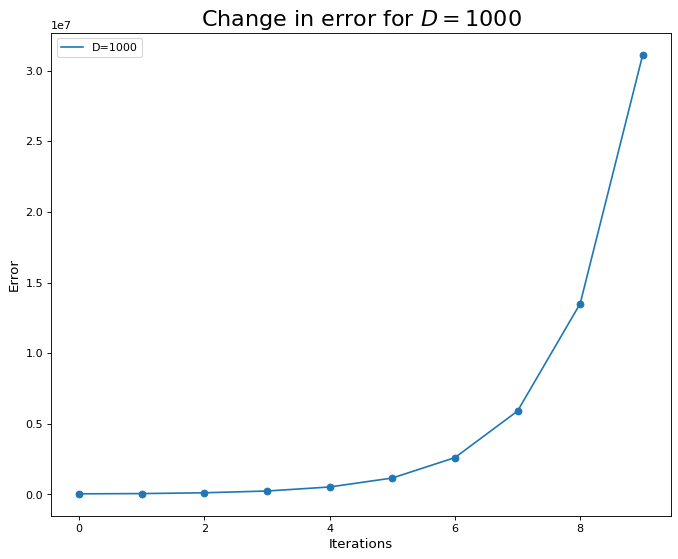

In [ ]:
figure(figsize=(10, 8), dpi=80)

plt.plot(range(iterations), error[1000])
plt.scatter(range(iterations), error[1000])

plt.legend(labels=["D=1000"])

plt.title("Change in error for $D=1000$", fontsize=20)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Error", fontsize=12)

plt.show()

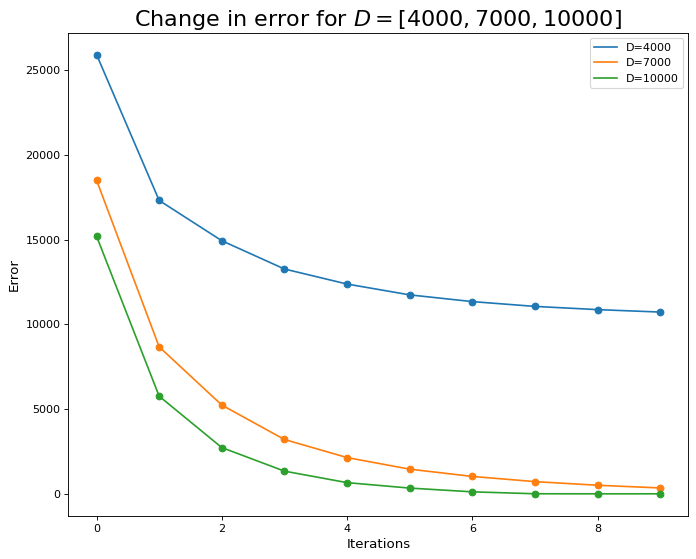

In [ ]:
figure(figsize=(10, 8), dpi=80)

plt.plot(range(iterations), error[4000])
plt.scatter(range(iterations), error[4000])
plt.plot(range(iterations), error[7000])
plt.scatter(range(iterations), error[7000])
plt.plot(range(iterations), error[10000])
plt.scatter(range(iterations), error[10000])

plt.legend(labels=["D=4000", "D=7000", "D=10000"])

plt.title("Change in error for $D = [4000, 7000, 10000]$", fontsize=20)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Error", fontsize=12)

plt.show()

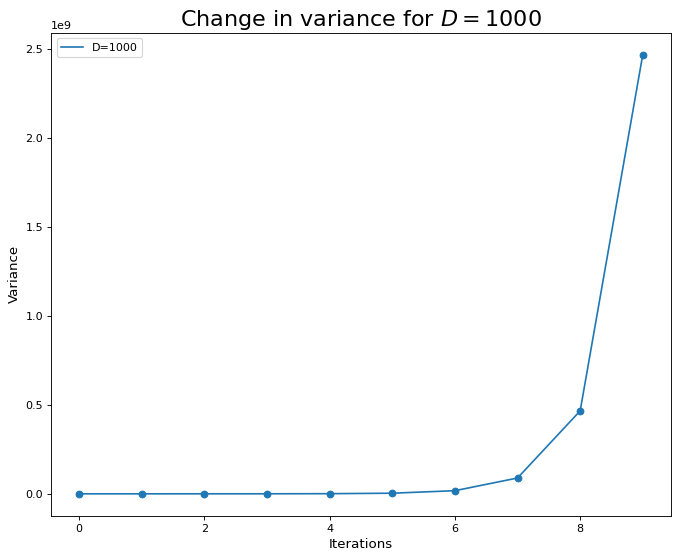

In [ ]:
figure(figsize=(10, 8), dpi=80)

plt.plot(range(iterations), var[1000])
plt.scatter(range(iterations), var[1000])

plt.legend(labels=["D=1000"])

plt.title("Change in variance for $D=1000$", fontsize=20)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Variance", fontsize=12)

plt.show()

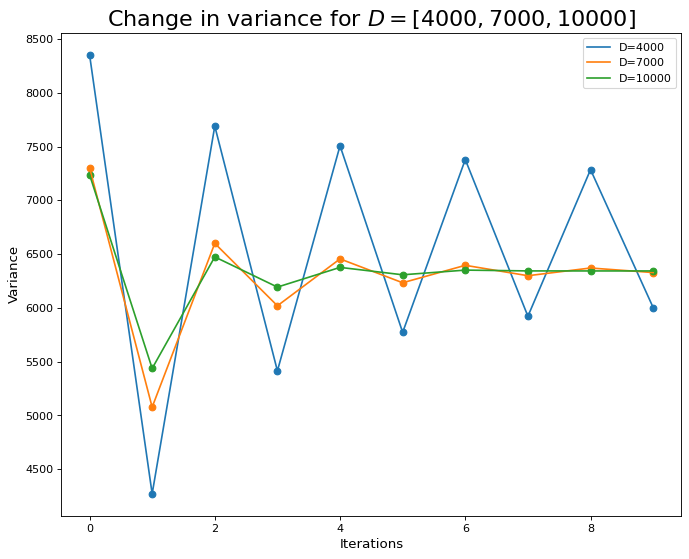

In [ ]:
figure(figsize=(10, 8), dpi=80)

plt.plot(range(iterations), var[4000])
plt.scatter(range(iterations), var[4000])
plt.plot(range(iterations), var[7000])
plt.scatter(range(iterations), var[7000])
plt.plot(range(iterations), var[10000])
plt.scatter(range(iterations), var[10000])

plt.legend(labels=["D=4000", "D=7000", "D=10000"])

plt.title("Change in variance for $D = [4000, 7000, 10000]$", fontsize=20)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Variance", fontsize=12)

plt.show()

## Experiment 2: Large image

In the second experiment, we run similar tests on a much larger image. 

### Experiment image

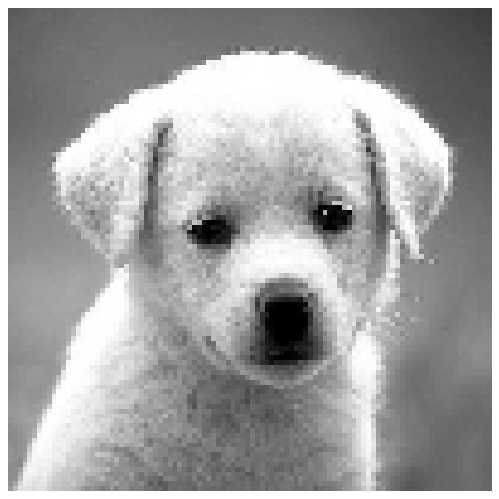

In [ ]:
puppy_url = "https://i.ibb.co/5L34dNV/B2-DBy-100x100.jpg"

puppy_im = Image.open(requests.get(puppy_url, stream=True).raw)

# puppy_im = Image.open(requests.get(puppy_url, stream=True).raw)
puppy_im = ImageOps.grayscale(puppy_im) 

puppy_array = np.array(puppy_im.getdata())

figure(figsize=(10, 8), dpi=80)

plt.imshow(puppy_array.reshape(100, 100), cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [ ]:
## Run each experiment independently so as to not run out of RAM 

# Variables to keep for the whole experiment 

iterations = 10 
P = {} 
variance = {} 
error    = {} 

### Decoding step

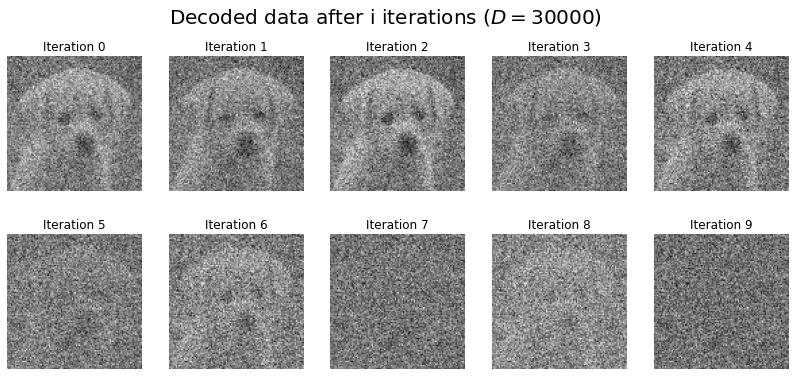

In [ ]:
## D = 30000 

# Prepare encoder 
p_30000 = HDEncoder(100 * 100, D=30000)

# Encode hypervector 
p_30000.encode(puppy_array)

# Decode hypervector 
P[30000] = p_30000.decode(iterations)

# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(P[30000][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded data after i iterations ($D=30000$)", fontsize=20)
plt.show()


# Delete HUGE encoder object 
del p_30000 

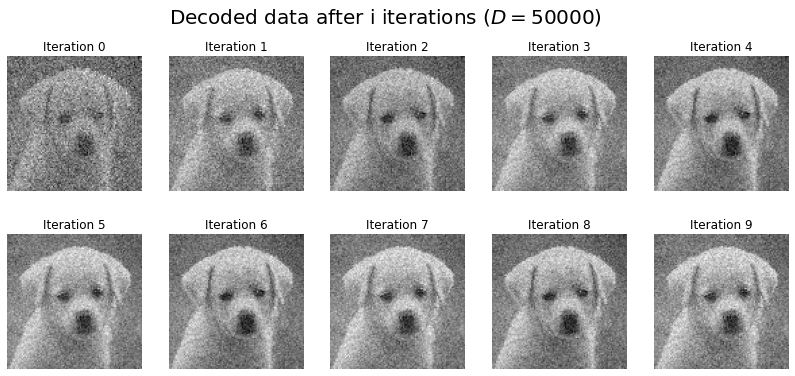

In [ ]:
## D = 50000 

# Prepare encoder 
p_50000 = HDEncoder(100 * 100, D=50000)

# Encode hypervector 
p_50000.encode(puppy_array)

# Decode hypervector 
P[50000] = p_50000.decode(iterations)

# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(P[50000][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded data after i iterations ($D=50000$)", fontsize=20)
plt.show()


# Delete HUGE encoder object 
del p_50000 

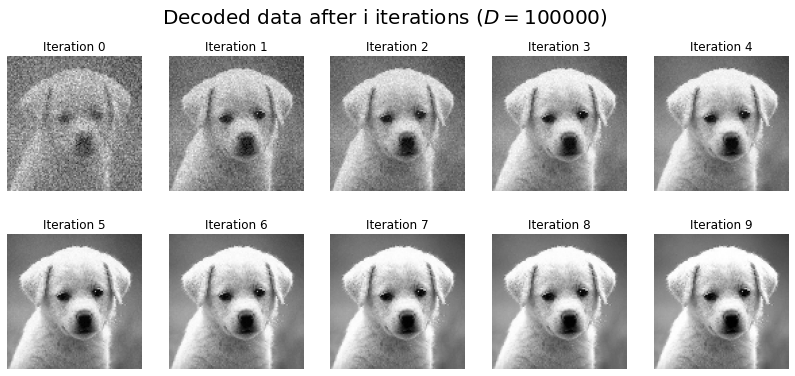

In [ ]:
## D = 100000 

# Prepare encoder 
p_100000 = HDEncoder(100 * 100, D=100000)

# Encode hypervector 
p_100000.encode(puppy_array)

# Decode hypervector 
P[100000] = p_100000.decode(iterations)

# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(P[100000][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded data after i iterations ($D=100000$)", fontsize=20)
plt.show()


# Delete HUGE encoder object 
del p_100000 

### Errors

In [ ]:
for d in [30000, 50000, 100000]:
  variance[d]   = [] 
  error[d] = []
  for i in range(iterations):
    variance[d].append(np.var(P[d][i]))
    e = hamming_error(P[d][i], puppy_array.reshape(10000))
    error[d].append(e)


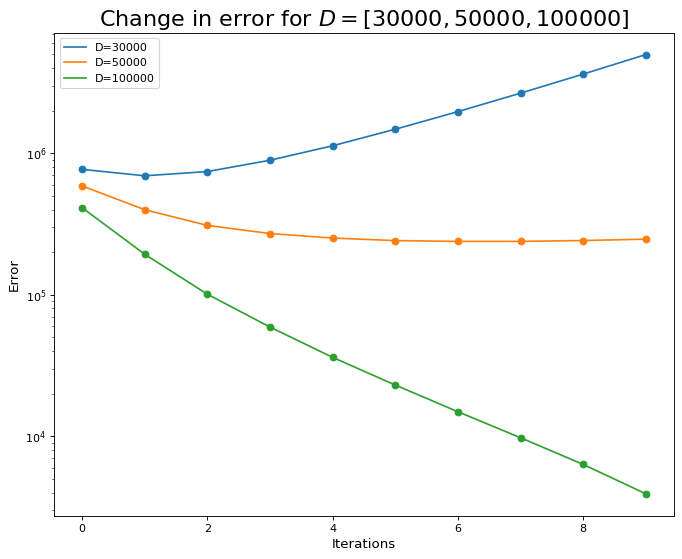

In [ ]:
figure(figsize=(10, 8), dpi=80)

plt.plot(range(iterations), error[30000])
plt.scatter(range(iterations), error[30000])
plt.plot(range(iterations), error[50000])
plt.scatter(range(iterations), error[50000])
plt.plot(range(iterations), error[100000])
plt.scatter(range(iterations), error[100000])

plt.legend(labels=["D=30000", "D=50000", "D=100000"])

plt.title("Change in error for $D = [30000, 50000, 100000]$", fontsize=20)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.yscale('log')

plt.show()

## Experiment 3: Information Loss

For this final experiment, we test how robust this reconstruction algorithm is against random information loss. We will fix the dimension as $D = 100000$, use the puppy image from experiment 2, and test the information loss on the results after the 10th iteration. 

In [ ]:
## Variables for testing 

# Dictionary to store decoded data for different levels of information loss
IL = {} 

# Dictionary to store error 
error_IL = {} 

### $0.1\%$ Loss

In [ ]:
## Drop 0.1% 

# Create encoder
il_100 = HDEncoder(100 * 100, D=100000)

# Encode puppy image 
il_100.encode(puppy_array)

# Drop 100 random indices 
il_100.drop_random(100)

# Decode the image 
IL[100] = il_100.decode(iterations)

# Garbage collection
del il_100 

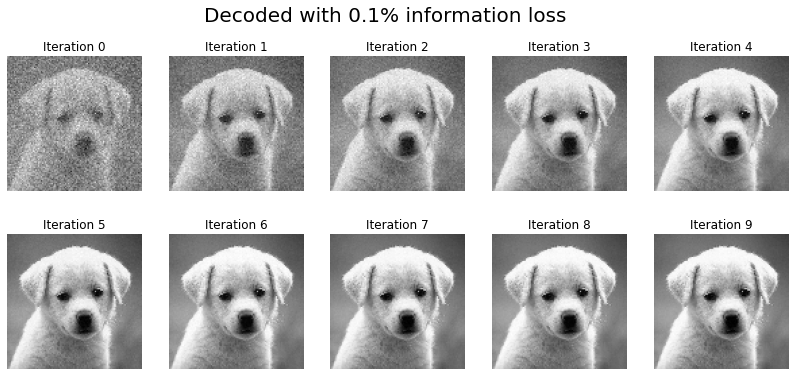

In [ ]:
# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(IL[100][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded with 0.1% information loss", fontsize=20)
plt.show()


### $1\%$ Loss

In [ ]:
## Drop 1% 

# Create encoder
il_1000 = HDEncoder(100 * 100, D=100000)

# Encode puppy image 
il_1000.encode(puppy_array)

# Drop 100 random indices 
il_1000.drop_random(1000)

# Decode the image 
IL[1000] = il_1000.decode(iterations)

# Garbage collection
del il_1000 

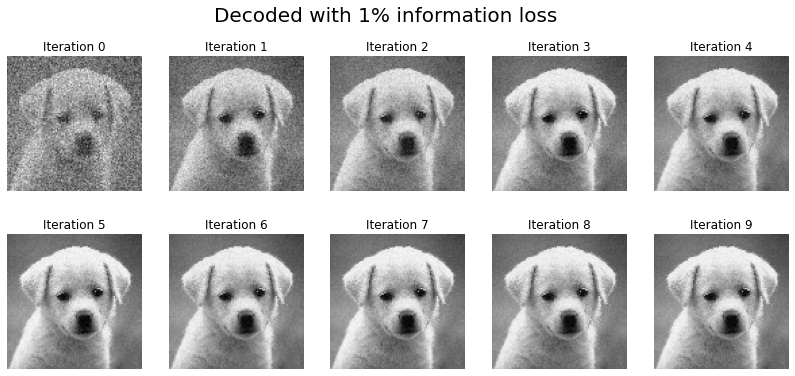

In [ ]:
# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(IL[1000][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded with 1% information loss", fontsize=20)
plt.show()


### $10\%$ Loss

In [ ]:
## Drop 10% 

# Create encoder
il_10000 = HDEncoder(100 * 100, D=100000)

# Encode puppy image 
il_10000.encode(puppy_array)

# Drop 100 random indices 
il_10000.drop_random(10000)

# Decode the image 
IL[10000] = il_10000.decode(iterations)

# Garbage collection
del il_10000 

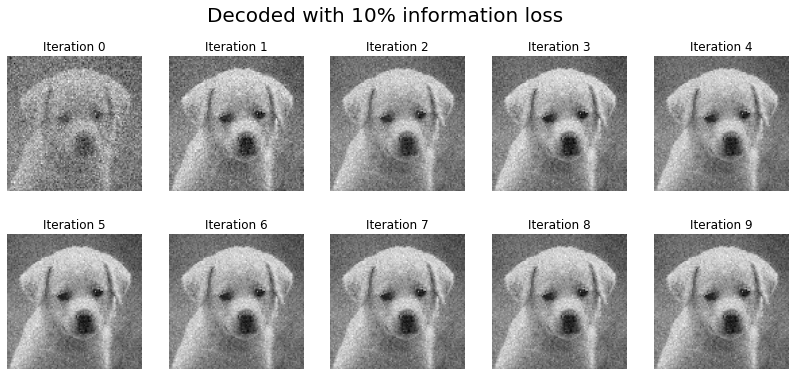

In [ ]:
# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(IL[10000][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded with 10% information loss", fontsize=20)
plt.show()


### $25\%$ Loss

In [ ]:
## Drop 25% 

# Create encoder
il_25000 = HDEncoder(100 * 100, D=100000)

# Encode puppy image 
il_25000.encode(puppy_array)

# Drop 100 random indices 
il_25000.drop_random(25000)

# Decode the image 
IL[25000] = il_25000.decode(iterations)

# Garbage collection 
del il_25000 

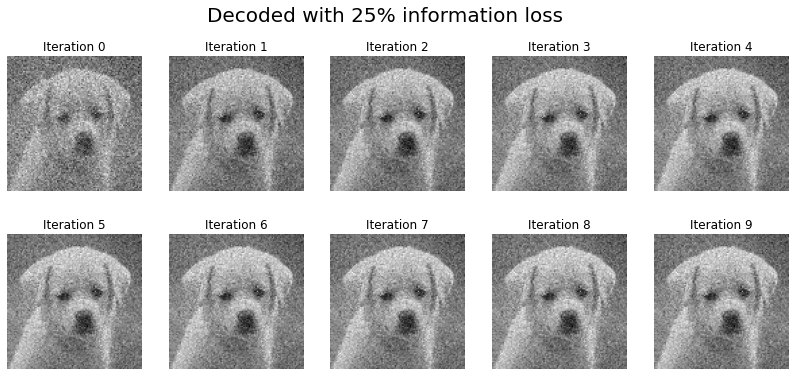

In [ ]:
# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(IL[25000][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded with 25% information loss", fontsize=20)
plt.show()


### $50\%$ Loss

In [ ]:
## Drop 50% 

# Create encoder
il_50000 = HDEncoder(100 * 100, D=100000)

# Encode puppy image 
il_50000.encode(puppy_array)

# Drop 100 random indices 
il_50000.drop_random(50000)

# Decode the image 
IL[50000] = il_50000.decode(iterations)

# Garbage collection 
del il_50000 

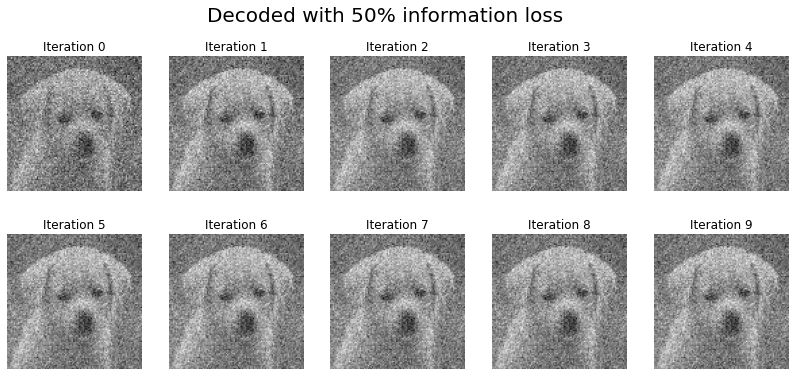

In [ ]:
# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(IL[50000][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded with 50% information loss", fontsize=20)
plt.show()


### $75\%$ Loss

In [ ]:
## Drop75% 

# Create encoder
il_75000 = HDEncoder(100 * 100, D=100000)

# Encode puppy image 
il_75000.encode(puppy_array)

# Drop 100 random indices 
il_75000.drop_random(75000)

# Decode the image 
IL[75000] = il_75000.decode(iterations)

# Garbage collection 
del il_75000 

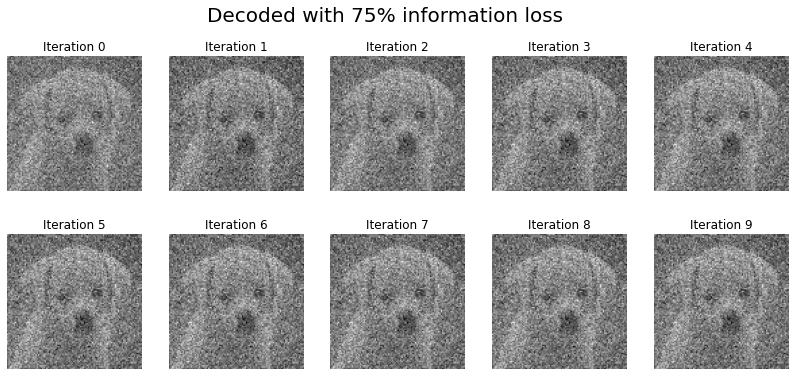

In [ ]:
# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
  idx = i//5 
  idy = i % 5
  axs[idx,idy].imshow(np.array(IL[75000][i]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx,idy].axis('off')
  axs[idx,idy].set_title(f'Iteration {i}')

fig.suptitle("Decoded with 75% information loss", fontsize=20)
plt.show()


### Results 

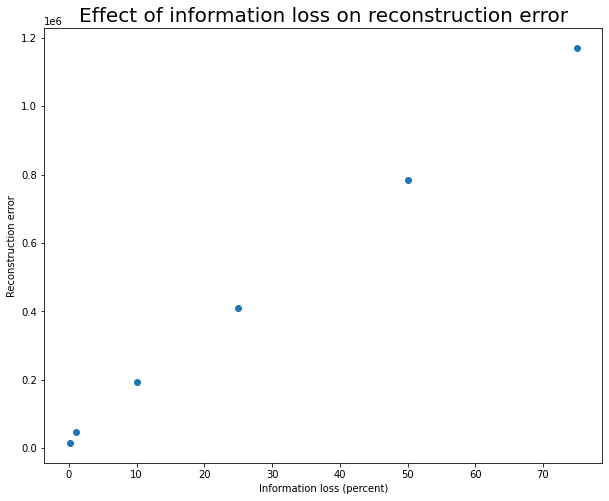

In [ ]:
for il in [100, 1000, 10000, 25000, 50000, 75000]:
  error_IL[il] = hamming_error(IL[il][9], puppy_array.reshape(10000))

x = [0.1, 1, 10, 25, 50, 75]

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x, error_IL.values()) 
ax.set_title("Effect of information loss on reconstruction error", fontsize=20)
ax.set_xlabel("Information loss (percent)")
ax.set_ylabel("Reconstruction error")
# for x0, y0, path in zip(x, y,paths):
#     ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
#     ax.add_artist(ab)

plt.show()

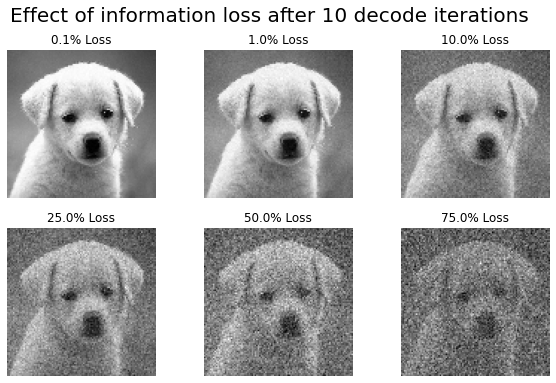

In [ ]:
# Plot each iteration of decoding 
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

for i, il in enumerate([100, 1000, 10000, 25000, 50000, 75000]):
  idx = i//3
  idy = i % 3

  axs[idx, idy].imshow(np.array(IL[il][9]).reshape(100, 100), cmap=plt.get_cmap('gray'))
  axs[idx, idy].axis('off')
  axs[idx, idy].set_title(f'{il/1000}% Loss')

fig.suptitle("Effect of information loss after 10 decode iterations", fontsize=20)
plt.show()


# Conclusion 

As expected, the accuracy of the decoding algorithm is much better when the dimension of the vector is high. A high dimensional vector also allows the reconstruction to occur in a much smaller number of iterations. 

Additionally, we see how robust this encoding scheme is to error. The image can be detected pretty well even with 75% information loss, and the quality is reasonably high for 10% information loss. 